## Movie Genre Prediction with TF-IDF

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/train_data.txt', header=None, names=['id', 'movie_name','genre', 'description'], sep=':::', index_col="id")

<ipython-input-3-794402f1729e>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv('/content/drive/MyDrive/train_data.txt', header=None, names=['id', 'movie_name','genre', 'description'], sep=':::', index_col="id")


In [ ]:
df

,movie_name,genre,description
id,,,
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."


### Exploration and Preprocessing

In [ ]:
df.head(2)

,movie_name,genre,description
id,,,
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...


In [ ]:
df.columns

Index(['movie_name', 'genre', 'description'], dtype='object')

Let's remove some information that we do not need and build another dataframe that contains "genre" and "description".

In [ ]:
# Create a new dataframe with two columns
df1 = df[['genre', 'description']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['description'])]

df1.shape

(54214, 2)

In [ ]:
# Percentage of descriptions that had text field
total = df1['description'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [ ]:
pd.DataFrame(df['genre'].unique()).values, len(pd.DataFrame(df['genre'].unique()).values)

(array([[' drama '],
        [' thriller '],
        [' adult '],
        [' documentary '],
        [' comedy '],
        [' crime '],
        [' reality-tv '],
        [' horror '],
        [' sport '],
        [' animation '],
        [' action '],
        [' fantasy '],
        [' short '],
        [' sci-fi '],
        [' music '],
        [' adventure '],
        [' talk-show '],
        [' western '],
        [' family '],
        [' mystery '],
        [' history '],
        [' news '],
        [' biography '],
        [' romance '],
        [' game-show '],
        [' musical '],
        [' war ']], dtype=object),
 27)

There are 27 different categories that we can use as out target variable. Let us make some changes in categories to avoid potential conflicts.

In [ ]:
# let's work with a smaller smaple of the data to speed things up
df2 = df1.sample(20000, random_state=1).copy()

In [ ]:
# Renaming categories to avoid conflicts
df2['genre'] = df2['genre'].str.strip()

df2.replace({"genre":
          {
                'action': 'action, adventure',
                'adventure': 'action, adventure',
                'war': 'action, adventure',
                'reality-tv': 'entertainment',
                'game-show': 'entertainment',
                'music': 'entertainment',
                'musical': 'entertainment',
                'talk-show': 'entertainment',
                'family': 'family, drama',
                'drama': 'family, drama',
                'adult': 'romance',
                'sci-fi': 'sci-fi fantasy',
                'fantasy': 'sci-fi fantasy',
                'thriller': 'thriller mystery',
                'mystery': 'thriller mystery',
                'news': 'biography, documentary, history, news, crime',
                'crime': 'biography, documentary, history, news, crime',
                'biography': 'biography, documentary, history, news, crime',
                'documentary': 'biography, documentary, history, news, crime',
                'history': 'biography, documentary, history, news, crime',
              }}, inplace=True)

In [ ]:
# Removing conflicting categories (western, short)
condition = (df2['genre'] == 'western') | (df2['genre'] == 'short')

df2 = df2.drop(df2[condition].index)
df2

,genre,description
id,,
10690,"biography, documentary, history, news, crime",This documentary film is a heartfelt glimpse ...
11730,"action, adventure",England Cricket hero Freddie Flintoff spends ...
1299,"biography, documentary, history, news, crime",Three gravediggers lovingly maintain the peac...
42665,"biography, documentary, history, news, crime","A man, Jean, is critically injured in a freak..."
40182,"family, drama","Roos and Rana are two friends, who both have ..."
...,...,...
21024,comedy,"Three colleagues (Carol Cheng, Joey Wong, San..."
23049,"family, drama","Jean, a wealthy young Canadian back from a tr..."
6783,"biography, documentary, history, news, crime",Journey into Life follows the struggles of th...


In [ ]:
pd.DataFrame(df2.genre.unique())
df2.genre.value_counts()

family, drama                                   5456
biography, documentary, history, news, crime    5225
comedy                                          2707
entertainment                                    898
horror                                           813
action, adventure                                803
thriller mystery                                 651
romance                                          491
sci-fi fantasy                                   380
animation                                        169
sport                                            151
Name: genre, dtype: int64

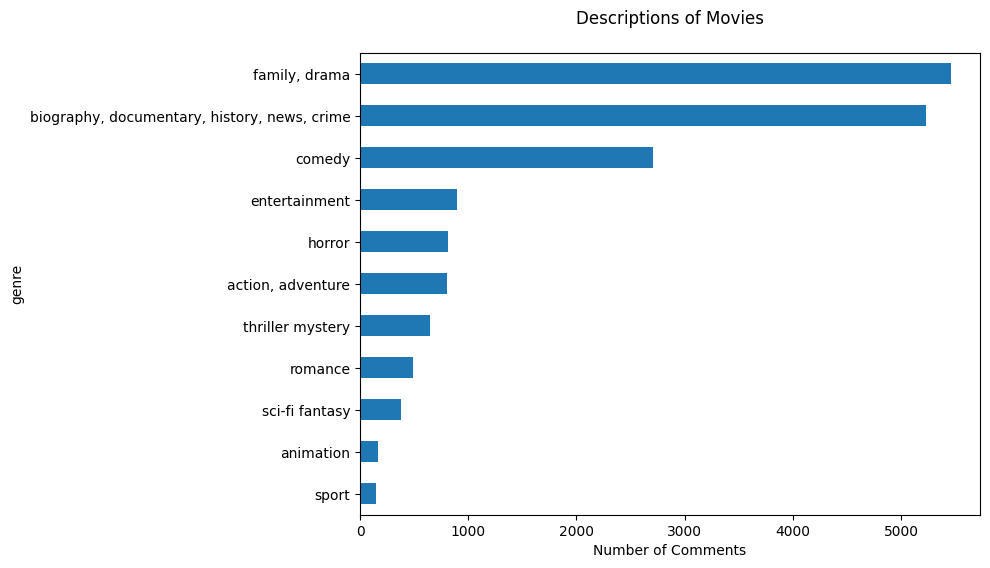

In [ ]:
fig = plt.figure(figsize=(8,6))
df2.groupby('genre').description.count().sort_values().plot.barh(
    ylim=0, title= 'Descriptions of Movies\n')
plt.xlabel('Number of Comments', fontsize = 10);

In [ ]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['genre'].factorize()[0]
category_id_df = df2[['genre', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'genre']].values)

# New dataframe
df2.head()

,genre,description,category_id
id,,,
10690,"biography, documentary, history, news, crime",This documentary film is a heartfelt glimpse ...,0
11730,"action, adventure",England Cricket hero Freddie Flintoff spends ...,1
1299,"biography, documentary, history, news, crime",Three gravediggers lovingly maintain the peac...,0
42665,"biography, documentary, history, news, crime","A man, Jean, is critically injured in a freak...",0
40182,"family, drama","Roos and Rana are two friends, who both have ...",2


Let us now calculate TF-IDF scores.

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each description into a vector
features = tfidf.fit_transform(df2.description).toarray()

labels = df2.category_id

print("Each of the %d description is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 17744 description is represented by 25784 features (TF-IDF score of unigrams and bigrams)


In [ ]:
# Finding the three most correlated terms with each of the genre categories
N = 3
for genre, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(genre))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> action, adventure:
  * Most Correlated Unigrams are: operative, martial, bondage
  * Most Correlated Bigrams are: bound gagged, action adventure, martial arts

==> animation:
  * Most Correlated Unigrams are: duck, superhero, animated
  * Most Correlated Bigrams are: story like, animated movie, whisked away

==> biography, documentary, history, news, crime:
  * Most Correlated Unigrams are: film, interviews, documentary
  * Most Correlated Bigrams are: documentary explores, length documentary, documentary film

==> comedy:
  * Most Correlated Unigrams are: sketch, hilarious, comedy
  * Most Correlated Bigrams are: hilarity ensues, sketch comedy, comedy series

==> entertainment:
  * Most Correlated Unigrams are: concert, music, contestants
  * Most Correlated Bigrams are: live performances, half hour, correct answer

==> family, drama:
  * Most Correlated Unigrams are: father, documentary, mother
  * Most Correlated Bigrams are: young woman, falls love, year old

==> horror:
  * M

### Classification

We start with a train-test split.

In [ ]:
X = df2['description'] # Collection of documents
y = df2['genre'] # Labels we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 20)

Let us train several models, namely,

*   Random Forest
*   Linear Support Vector Machine
*   Multinomial Naive Bayes
*   Logistic Regression

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.628607,0.009626
LogisticRegression,0.620435,0.009953
MultinomialNB,0.535054,0.004908
RandomForestClassifier,0.499492,0.005616


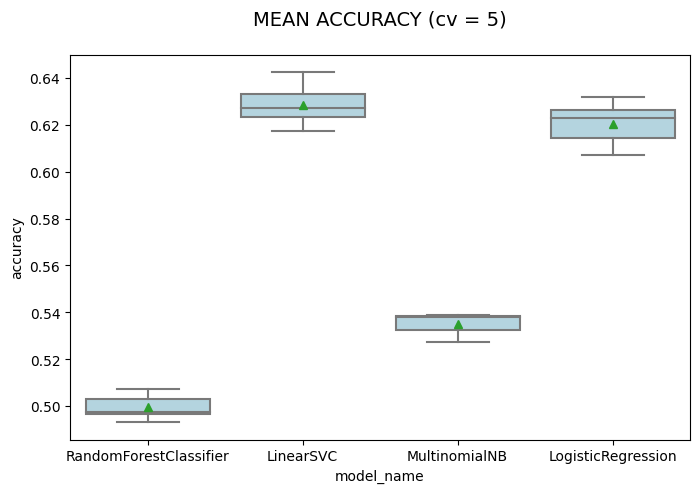

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

Evaluation

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df2.index, test_size=0.25, random_state=1)

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, target_names= df2['genre'].unique()))

				CLASSIFICATIION METRICS

                                              precision    recall  f1-score   support

biography, documentary, history, news, crime       0.72      0.84      0.77      1329
                           action, adventure       0.39      0.22      0.28       193
                               family, drama       0.61      0.73      0.67      1369
                                      comedy       0.53      0.56      0.54       663
                            thriller mystery       0.42      0.13      0.20       172
                               entertainment       0.62      0.31      0.41       235
                                     romance       0.62      0.20      0.30       121
                                      horror       0.68      0.60      0.64       192
                                   animation       0.33      0.03      0.05        36
                              sci-fi fantasy       0.48      0.24      0.32        89
                        

Confusion Matrix

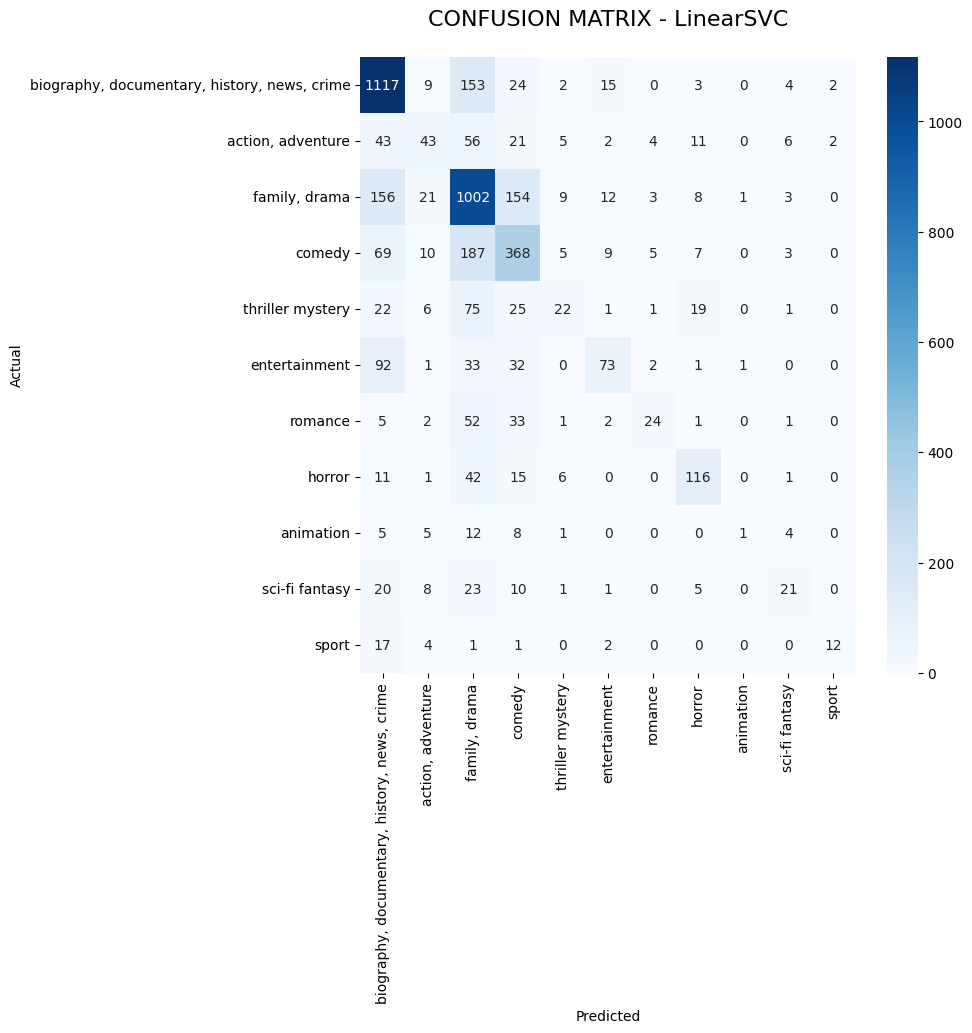

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

### Analysing Results

Let’s have a look at the texts that were wrongly classified.

In [ ]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['genre',
                                                                'description']])
      print('')

'action, adventure' predicted as 'biography, documentary, history, news, crime' : 43 examples.


,genre,description
id,,
53224,"action, adventure","Mars, 2044. The UN establishes MARSCORP (Mart..."
39452,"action, adventure",Writen by award winning filmmaker Damian Perk...
30765,"action, adventure",James and John are working in the Commercial ...
26040,"action, adventure",Starostin brothers are the sons of a legendar...
3678,"action, adventure",The three-season series Poyraz Karayel will f...
14118,"action, adventure",Johnny Weissmuller guides Professor Blakely a...
44445,"action, adventure",Croc Labyrinth Brad and Vince have succeeded ...
17625,"action, adventure",An expedition into the interior of Papua New ...
22694,"action, adventure","There is nothing fair, honorable, or just abo..."



'family, drama' predicted as 'biography, documentary, history, news, crime' : 156 examples.


,genre,description
id,,
34444,"family, drama",Kaori is pursuing her career as a journalist ...
41124,"family, drama",The film shows an obscure episode from the li...
20369,"family, drama","It is a futuristic story, which takes place i..."
21769,"family, drama","""The Forgotten Four: Immortality"" acts as a b..."
21915,"family, drama","Latest example of Spanish ""neokinki"" cinema, ..."
...,...,...
25275,"family, drama",Shake is a powerful shaman of the Yanomami pe...
2546,"family, drama","The silent film ""Gypsy Girl in the Bedroom""(1..."
39438,"family, drama",A young extraterrestrial woman undergoing cos...



'comedy' predicted as 'biography, documentary, history, news, crime' : 69 examples.


,genre,description
id,,
36128,comedy,"Tthe film is based on the concept of ""New Ame..."
51751,comedy,Funhaus is a YouTube gaming channel working u...
5734,comedy,"Dwight Serrento, once a pop-icon is now reduc..."
35172,comedy,Rudy is an American of Mexican descent who is...
28557,comedy,"iBox is a bilingual, humoristic and provocati..."
...,...,...
7675,comedy,Lab technician Virgil Gurdies embarks on an e...
38016,comedy,"Like many who grew up in the 1980s, John Tavi..."
8934,comedy,"""Relatively Well"" follows Dave's journey to s..."



'thriller mystery' predicted as 'biography, documentary, history, news, crime' : 22 examples.


,genre,description
id,,
6995,thriller mystery,A secret society of financiers known as the Q...
21049,thriller mystery,A lab in Mexico creates a time machine. One d...
23869,thriller mystery,A political thriller during the Wounded Knee ...
38312,thriller mystery,"Lola, a young graduate in architecture at the..."
27798,thriller mystery,"In Kreuzberg, Berlin, the Turkish gangs of im..."
2624,thriller mystery,"On February 14th, 2007 a website titled ""Mang..."
22058,thriller mystery,Atithi Devo Bhava means 'The guest is equival...
14491,thriller mystery,50 Years after World War II Hitler's deadly '...
9247,thriller mystery,"American film maker Arthur Stoddard, his girl..."



'entertainment' predicted as 'biography, documentary, history, news, crime' : 92 examples.


,genre,description
id,,
43834,entertainment,There are about 3 million hoarders in the Uni...
50115,entertainment,"With news of their grandmother's passing, a g..."
30136,entertainment,Backroads with Ron and Raven celebrates the o...
16245,entertainment,Series casts off from San Pedro Island in Bel...
38763,entertainment,Big Green Lies is a show dedicated to cutting...
...,...,...
33382,entertainment,Quest burns the heroic lives and rides of gia...
26054,entertainment,Allegiance illuminates one of American histor...
14391,entertainment,Showcase for talented youth of Hispanic Herit...



'sci-fi fantasy' predicted as 'biography, documentary, history, news, crime' : 20 examples.


,genre,description
id,,
35906,sci-fi fantasy,String Theory is a new Science Fiction series...
49391,sci-fi fantasy,An investigation into the tragic end of Apoll...
32557,sci-fi fantasy,A criminal organization known as OSO speciali...
1610,sci-fi fantasy,"This expansion of Edu-Ware's ""Space"" role-pla..."
48104,sci-fi fantasy,The Upper West Side has some of the tallest b...
9328,sci-fi fantasy,A giant spaceship carrying colonists to a new...
7057,sci-fi fantasy,"In what remains of the world there is no war,..."
42241,sci-fi fantasy,"A rapid journey through time and space, creat..."
10112,sci-fi fantasy,"Ash has the power to communicate with ETs, a ..."



'family, drama' predicted as 'action, adventure' : 21 examples.


,genre,description
id,,
918,"family, drama",An unauthorised remake of Hitchcock's classic...
20767,"family, drama",25 years after fleeing Cambodia for the Phili...
23574,"family, drama","In upscale Opulent, Arizona, Edward Pierce, m..."
22218,"family, drama",A pre-World War II saber-rattler that finds a...
17006,"family, drama",Set in the closed and poisonous world of an i...
36364,"family, drama","In the future (1921), an alliance of several ..."
4901,"family, drama","Fourteen years ago, Wai Yat Ming (Ti Lung) we..."
41191,"family, drama","In 18th-Century Russia, the Czar, Paul, is su..."
3026,"family, drama",The Story is about a boy named Premji (played...



'biography, documentary, history, news, crime' predicted as 'family, drama' : 153 examples.


,genre,description
id,,
38162,"biography, documentary, history, news, crime",Following the world's youngest transsexual as...
21048,"biography, documentary, history, news, crime",In the aftermath of the fatal Airbus A320 acc...
35772,"biography, documentary, history, news, crime","Afrikaner Juan van Tonder, bon vivant of Cape..."
31261,"biography, documentary, history, news, crime",Two people fall in love even though the conve...
47948,"biography, documentary, history, news, crime","Miguel de Uamuno, a Spanish writer and philos..."
...,...,...
40342,"biography, documentary, history, news, crime",Castmembers from the highly popular MTV serie...
27850,"biography, documentary, history, news, crime",Corruption has eaten away at the hearts of tw...
44952,"biography, documentary, history, news, crime",After A Suicide - Moving Past Why tells the s...



'action, adventure' predicted as 'family, drama' : 56 examples.


,genre,description
id,,
40881,"action, adventure",This urban drama is based on a shocking true ...
28844,"action, adventure",ACTION/THRILLER Red is the color that we pay ...
51756,"action, adventure",A beautiful con-woman claims to be Kelsie's l...
11271,"action, adventure",A young kenpo karate martial artist returns h...
36386,"action, adventure",A female police rookie wants to remain partne...
25,"action, adventure",Dong-woo is released from prison after a shor...
32100,"action, adventure",Arun (Rajinikanth) is the haughty and bellige...
16627,"action, adventure",The story begins with a man Arjun(mithun) wor...
16720,"action, adventure",North Korean spy Jang Duk begins to have his ...



'comedy' predicted as 'family, drama' : 187 examples.


,genre,description
id,,
18013,comedy,This is love stories of different generations...
2089,comedy,"Primitive, cowardly, greedy and fame seeking ..."
14634,comedy,The most important celluloid in all of animat...
3279,comedy,Garage Daze is the story of a former high sch...
3806,comedy,Kaat leaves Max the day after her thirtieth b...
...,...,...
5987,comedy,"Three young housewives, feeling neglected and..."
29155,comedy,"Text "" Plot Edit Jimmy (Jimmy Sharma) and Roc..."
14159,comedy,Pluto can't help himself. Adopting the roles ...



'thriller mystery' predicted as 'family, drama' : 75 examples.


,genre,description
id,,
22759,thriller mystery,"Sarah Mitchell, a loyal and loving young wife..."
536,thriller mystery,"In the children's ward of St Luke's Hospital,..."
42268,thriller mystery,Through the redemption of a former torturer o...
6779,thriller mystery,High school student Juri leaps to her death. ...
26077,thriller mystery,After narrowly avoiding death in a tragic acc...
...,...,...
50831,thriller mystery,"In a bustling Tel Aviv, a man suffering from ..."
53804,thriller mystery,A shocking tale of young innocence facing a s...
25705,thriller mystery,Shubhada is hit by Dr Ajinkiya Vartak's car a...



'entertainment' predicted as 'family, drama' : 33 examples.


,genre,description
id,,
23335,entertainment,"""Lapsed Catholics"", once upon a time the bigg..."
33805,entertainment,"We all have it. A junk drawer, a messy closet..."
51627,entertainment,S4K's Romeo & Juliet is set in Verona and tel...
40012,entertainment,"The Earl of Essex, Robert Devereux, is hot-bl..."
3005,entertainment,"""The Tony Fontane Story"" is a dramatization o..."
50131,entertainment,GIVE ME SHELTER takes the perennially success...
51215,entertainment,Like a favorite aunt who comes calling when y...
11180,entertainment,The film's plot follows a young girl who is a...
6666,entertainment,Macushlah was raised by Father O'Flynn after ...



'romance' predicted as 'family, drama' : 52 examples.


,genre,description
id,,
48616,romance,The story of Yeh Kahan Aa gaye Hum is about a...
1321,romance,"At 14, Diane is an enigmatic teenager and a l..."
49100,romance,Nell (Justine Joli) has a wonderful business;...
9507,romance,"After suffering an accident, which places him..."
49043,romance,Crystal Wylder is the forewoman on a jury del...
18864,romance,Ashley Lauren turns a relaxing trailer park i...
18466,romance,"Türkan's mother, a singer in a cheap night cl..."
38294,romance,Releasing on the eve of the 10th anniversary ...
48667,romance,The story starts out with Kit and Mun being c...



'horror' predicted as 'family, drama' : 42 examples.


,genre,description
id,,
8928,horror,Brittany is a spoiled teenage-girl who ventur...
53202,horror,An old man who lives in an old house conducts...
11653,horror,Six people are brought together at the funera...
5441,horror,"In the British countryside, the Harver family..."
9195,horror,Christine Villier is betrothed to Jacques Des...
21056,horror,"During one twenty-four hour period, the lives..."
17887,horror,A newly engaged young woman gets into an acci...
21487,horror,"In 1953, nestled deep in the unforgiving Sibe..."
39124,horror,Professor Nugent and his students embark on a...



'sci-fi fantasy' predicted as 'family, drama' : 23 examples.


,genre,description
id,,
6013,sci-fi fantasy,Amber and friends follow her sister Senna int...
12453,sci-fi fantasy,"Dr. Jin, the top surgeon in Korea in the 21st..."
47244,sci-fi fantasy,Akash is lonely real estate agent who uses vi...
45205,sci-fi fantasy,Frankie in Blunderland tells the story of Fra...
29868,sci-fi fantasy,John Carson is a worldly man of means. Living...
50332,sci-fi fantasy,Community-oriented film project following som...
8147,sci-fi fantasy,A religious guy find himself facing his demon...
5721,sci-fi fantasy,When an old key is left to a young woman by h...
1805,sci-fi fantasy,The Boy on the Bus is a magical realism fable...



'biography, documentary, history, news, crime' predicted as 'comedy' : 24 examples.


,genre,description
id,,
23952,"biography, documentary, history, news, crime","Jonathan Rendall's broke, he's been given Ł12..."
18952,"biography, documentary, history, news, crime","November 12, the Lindbergh couple alighted in..."
287,"biography, documentary, history, news, crime","On his first burglary, a locksmith finds hims..."
15942,"biography, documentary, history, news, crime","One summer in S&M and leather. Chicago, New Y..."
20880,"biography, documentary, history, news, crime",Hired by a surveillance company to oversee th...
31920,"biography, documentary, history, news, crime",A story about four neighborhood boys who like...
21624,"biography, documentary, history, news, crime","""New York vs Los Angeles"" pits the two very d..."
10858,"biography, documentary, history, news, crime","Naina is driven by the motto ""Shoot for the m..."
42543,"biography, documentary, history, news, crime",Paolo Virno is one of today's most influentia...



'action, adventure' predicted as 'comedy' : 21 examples.


,genre,description
id,,
52954,"action, adventure","Cleo inherits an adult bookstore, but her unc..."
52851,"action, adventure",Young heiress Helen Stuart is engaged to Mont...
5223,"action, adventure","Carly Banks, a movie actress desperate for wo..."
47484,"action, adventure",The war veteran Jim (Reed Howes) is an airpla...
44544,"action, adventure","It's been one year since the ""Overachievers"" ..."
5529,"action, adventure",Windup is a very original comedy. We follow B...
44791,"action, adventure",IT IS A STORY OF A BOY SACHIN WHO IS VERY KIN...
5911,"action, adventure","Late in World War II, an inexperienced U.S. o..."
18348,"action, adventure",There's trouble at the local television stati...



'family, drama' predicted as 'comedy' : 154 examples.


,genre,description
id,,
2301,"family, drama",Be the Church centers around the life of a 20...
21297,"family, drama",Terry Willis grew up like many youths with dr...
3827,"family, drama",It's a based of members from a youtube channe...
25522,"family, drama","Alex Calder (Julia Denton Frances), a journal..."
5453,"family, drama",A movie director is approached by his old mat...
...,...,...
13043,"family, drama",Rides is a British television series produced...
14666,"family, drama",Single mom Dottie Ingels sells cosmetics in a...
13828,"family, drama",A comedy of errors where two military officer...



'thriller mystery' predicted as 'comedy' : 25 examples.


,genre,description
id,,
6747,thriller mystery,Peter Sommer is the candidate of his party fo...
26359,thriller mystery,The Screech Owls are one of the great contend...
14986,thriller mystery,The film tells the story of chartered account...
36320,thriller mystery,Iris is a discontent acting major and residen...
21503,thriller mystery,"Armand is thirty-some years old, who immigrat..."
25790,thriller mystery,Konrad von Seidlitz is a young yuppie lawyer ...
14063,thriller mystery,Aaron Anderson wants to make a scary movie. H...
48076,thriller mystery,Someone is going around killing Uber Cab Driv...
22074,thriller mystery,"A serial killer, called the Iguana, is terror..."



'entertainment' predicted as 'comedy' : 32 examples.


,genre,description
id,,
51298,entertainment,C'est une émission de variétés française anim...
49744,entertainment,A wacky musical following a torch song lounge...
43377,entertainment,A popular late-night variety show in Japan. T...
45265,entertainment,Senioritis is a musical comedy about today's ...
35309,entertainment,10 great punk rock classics presented karaoke...
25823,entertainment,It's time for Billy to challenge his wine-sel...
12598,entertainment,Social media music video superstar Adam Barta...
26711,entertainment,Every episode has a Style Theme that best rep...
5013,entertainment,"The Jet Set is a fresh, new, first of-its-kin..."



'romance' predicted as 'comedy' : 33 examples.


,genre,description
id,,
23875,romance,"A comedy about Ted, feeling trapped in his ma..."
53414,romance,Filmed on location in the crystal waters of t...
29577,romance,A small-town girl goes to New York hoping to ...
39857,romance,"An advertising executive, Senthil (Cheran) ta..."
26617,romance,Billy works as a maintenance guy in a luxury ...
10245,romance,The headmaster of a small British public scho...
42376,romance,Charmane Star is a beautiful Asian actress st...
30225,romance,"Shurik is a talented designer, but like every..."
27885,romance,"Arsala comes to her home, as she thinks her p..."


Most correlated terms with each category¶


In [ ]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'action, adventure':
  * Top unigrams: adventure, bondage, wwf, platoon
  * Top bigrams: action adventure, martial arts, desert island, bad guys

==> 'animation':
  * Top unigrams: animated, adventures, duck, superhero
  * Top bigrams: time travel, man man, story like, whisked away

==> 'biography, documentary, history, news, crime':
  * Top unigrams: documentary, interviews, portrait, reveal
  * Top bigrams: make film, 60 years, real story, story friendship

==> 'comedy':
  * Top unigrams: comedy, hilarious, mockumentary, misadventures
  * Top bigrams: best friends, married woman, york city, film crew

==> 'entertainment':
  * Top unigrams: contestants, musical, songs, hosted
  * Top bigrams: reality series, music video, young people, romeo juliet

==> 'family, drama':
  * Top unigrams: drama, tokyo, based, drifter
  * Top bigrams: feature film, wedding night, black comedy, woman life

==> 'horror':
  * Top unigrams: horror, vampire, evil, zombies
  * Top bigrams: horror film, ye

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Let's come up with a new descriptions and see how our model does.



**1. Whisper of the Heart**

* **Genre**: Romance, Animation

In [ ]:
new_description = """Hey, just watched "Whisper of the Heart" and it's awesome! It's a sweet coming-of-age story about a girl finding her passion for writing. Loved the relatable characters and the beautiful animation. Only downside, I wish there was more of the fantasy element hinted in the beginning. Overall, a heartwarming flick!"""
print(model.predict(fitted_vectorizer.transform([new_description])))

['family, drama']


**2. The Conjuring: The Devil Made Me Do It.**

* **Genre**: Horror



In [ ]:
new_description = """Hey, just watched "The Conjuring: The Devil Made Me Do It." It was super scary with lots of intense moments that kept me on the edge of my seat. Loved how they mixed horror with a detective vibe. Only downside, some scenes felt a bit rushed, but overall, a solid spooky time!"""
print(model.predict(fitted_vectorizer.transform([new_description])))

['horror']


**3. Jurassic World**

* **Genre**: Action, Adventure

In [ ]:
new_description = """Jurassic World was a wild ride! The dinosaurs were jaw-dropping, and the excitement never let up. I loved the action, but some moments were a bit cheesy, and the story was kinda predictable. Overall, though, it's a thrilling watch!"""
print(model.predict(fitted_vectorizer.transform([new_description])))

['action, adventure']
